In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# Load the datasets
humidity_file_path = "C:/Users/Ohellay/Desktop/humidity_file.csv"  # Replace with your file path
temperature_file_path = "C:/Users/Ohellay/Desktop/temperature_file.csv"  # Replace with your file path

humidity_data = pd.read_csv(humidity_file_path)
temperature_data = pd.read_csv(temperature_file_path)

# Replace station IDs with station names
station_name_map = {
    "DNAA": "Abuja", "DNAK": "Akure", "DNBE": "Benin", "DNCA": "Calabar", "DNEN": "Enugu",
    "DNGO": "Gombe", "DNIB": "Ibadan", "DNIL": "Ilorin", "DNIM": "Imo", "DNJO": "Jos",
    "DNKA": "Kaduna", "DNKN": "Kano", "DNKT": "Katsina", "DNMA": "Maiduguri", "DNMK": "Makurdi",
    "DNMM": "Lagos", "DNMN": "Minna", "DNOS": "Osogbo", "DNPO": "Port Harcourt", "DNSO": "Sokoto",
    "DNYO": "Yola", "DNZA": "Zaria"
}

humidity_data['station'] = humidity_data['station'].map(station_name_map)
temperature_data['station'] = temperature_data['station'].map(station_name_map)

# Convert 'relh' and 'tmpc' columns to numeric
humidity_data['relh'] = pd.to_numeric(humidity_data['relh'], errors='coerce')
temperature_data['tmpc'] = pd.to_numeric(temperature_data['tmpc'], errors='coerce')

# Drop rows with NaN values
humidity_data_cleaned = humidity_data.dropna(subset=['relh'])
temperature_data_cleaned = temperature_data.dropna(subset=['tmpc'])

# Extract numeric values
temperature_values = temperature_data_cleaned['tmpc'].values
humidity_values = humidity_data_cleaned['relh'].values

# Define a function to fit distributions and calculate AIC/BIC
def fit_distribution(data, dist_name, dist):
    params = dist.fit(data)
    log_likelihood = np.sum(dist.logpdf(data, *params))
    k = len(params)  # Number of parameters
    aic = 2 * k - 2 * log_likelihood
    bic = k * np.log(len(data)) - 2 * log_likelihood

    # Map parameter names based on distribution
    if dist_name in ["Gamma", "Weibull"]:
        param_names = ["Shape", "Location", "Scale"]
    elif dist_name == "Exponential":
        param_names = ["Location", "Scale"]
    elif dist_name == "Normal":
        param_names = ["Mean", "Standard Deviation"]
    else:
        param_names = [f"Param {i+1}" for i in range(len(params))]

    param_dict = {name: p for name, p in zip(param_names, params)}
    return {"name": dist_name, "log_likelihood": log_likelihood, "AIC": aic, "BIC": bic, **param_dict}

# Distributions to fit
distributions = {
    "Gamma": stats.gamma,
    "Weibull": stats.weibull_min,
    "Exponential": stats.expon,
    "Normal": stats.norm
}

# Fit distributions for temperature
temp_fits = [fit_distribution(temperature_values, name, dist) for name, dist in distributions.items()]

# Fit distributions for humidity
humidity_fits = [fit_distribution(humidity_values, name, dist) for name, dist in distributions.items()]

# Sort by AIC to identify the best-fitting distribution
temp_fits_sorted = sorted(temp_fits, key=lambda x: x['AIC'])
humidity_fits_sorted = sorted(humidity_fits, key=lambda x: x['AIC'])

# Convert results to DataFrames for better presentation
temp_fits_df = pd.DataFrame(temp_fits_sorted)
humidity_fits_df = pd.DataFrame(humidity_fits_sorted)

# Save results to CSV for documentation
temp_fits_df.to_csv("temperature_fits.csv", index=False)
humidity_fits_df.to_csv("humidity_fits.csv", index=False)


In [3]:
print("Temperature Distribution Fits (Sorted by AIC):")
temp_fits_df

Temperature Distribution Fits (Sorted by AIC):


,name,log_likelihood,AIC,BIC,Shape,Location,Scale,Mean,Standard Deviation
0,Gamma,-1.608631e+06,3.217267e+06,3.217301e+06,672.056156,-84.560459,0.166666,NaN,NaN
1,Normal,-1.608875e+06,3.217754e+06,3.217776e+06,NaN,NaN,NaN,27.44727,4.31554
2,Exponential,-2.800678e+06,5.601359e+06,5.601382e+06,NaN,-28.000000,55.447270,NaN,NaN
3,Weibull,-inf,inf,inf,6.674514,-0.016362,29.304521,NaN,NaN


In [4]:
print("\nHumidity Distribution Fits (Sorted by AIC):")
humidity_fits_df


Humidity Distribution Fits (Sorted by AIC):


,name,log_likelihood,AIC,BIC,Shape,Location,Scale,Mean,Standard Deviation
0,Weibull,-2.510564e+06,5.021133e+06,5.021167e+06,1.812301e+08,-3.234292e+09,3.234292e+09,NaN,NaN
1,Normal,-2.573888e+06,5.147781e+06,5.147803e+06,NaN,NaN,NaN,69.129826,24.448295
2,Gamma,-2.581020e+06,5.162046e+06,5.162080e+06,4.808240e+02,-4.761682e+02,1.134294e+00,NaN,NaN
3,Exponential,-2.912521e+06,5.825046e+06,5.825068e+06,NaN,9.100000e-01,6.821983e+01,NaN,NaN


In [5]:
from scipy.stats import skew, kurtosis

# Define the descriptive statistics function
def descriptive_stats(data, label):
    """
    Calculates and displays descriptive statistics for the given data.
    
    Parameters:
    - data: A Pandas Series or numpy array containing the data.
    - label: A string label for the data (e.g., "Temperature", "Humidity").
    
    Returns:
    A dictionary of descriptive statistics.
    """
    stats = {
        "Mean": np.mean(data),
        "Median": np.median(data),
        "Standard Deviation": np.std(data),
        "Variance": np.var(data),
        "Minimum": np.min(data),
        "Maximum": np.max(data),
        "Skewness": skew(data),
        "Kurtosis": kurtosis(data)
    }
    
    # Display the results
    print(f"\nDescriptive Statistics for {label}:")
    for stat, value in stats.items():
        print(f"{stat}: {value:.2f}")
    
    return stats

# Calculate descriptive statistics for temperature and humidity
temp_stats = descriptive_stats(temperature_values, "Temperature ")
humidity_stats = descriptive_stats(humidity_values, "Humidity")

# Combine all descriptive statistics into a DataFrame
descriptive_stats_df = pd.DataFrame({
    "Statistic": list(temp_stats.keys()),
    "Temperature": list(temp_stats.values()),
    "Humidity": list(humidity_stats.values())
})

# Save to CSV
output_file = "descriptive_statistics.csv"
descriptive_stats_df.to_csv(output_file, index=False)

print("\nDescriptive statistics have been calculated and saved to:")
print(output_file)


Descriptive Statistics for Temperature :
Mean: 27.45
Median: 27.00
Standard Deviation: 4.32
Variance: 18.62
Minimum: -28.00
Maximum: 65.00
Skewness: 0.10
Kurtosis: 0.79

Descriptive Statistics for Humidity:
Mean: 69.13
Median: 74.77
Standard Deviation: 24.45
Variance: 597.72
Minimum: 0.91
Maximum: 100.00
Skewness: -0.83
Kurtosis: -0.40

Descriptive statistics have been calculated and saved to:
descriptive_statistics.csv


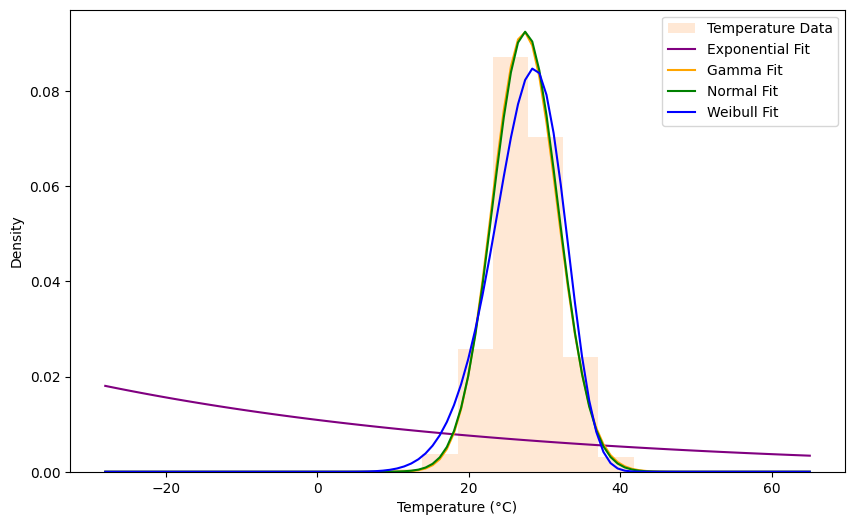

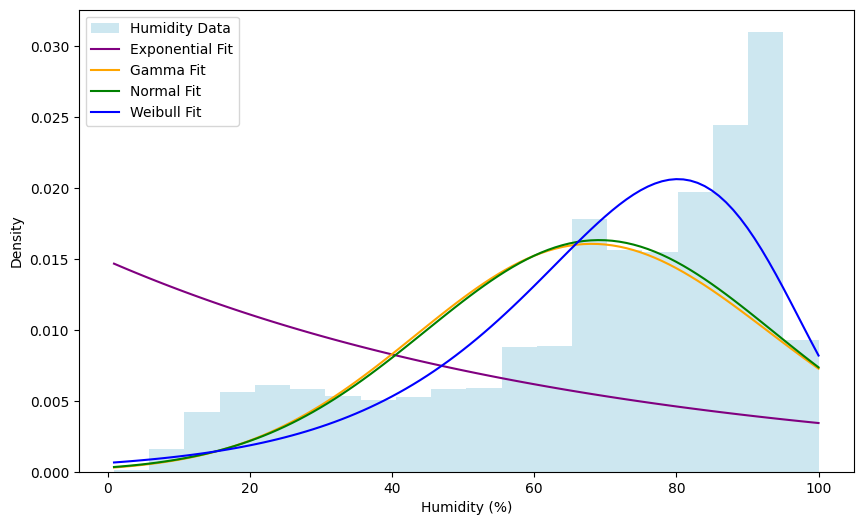

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Prepare data series
nigeria_temperature_series = temperature_values  # Use the temperature values from your dataset
nigeria_humidity_series = humidity_values  # Use the humidity values from your dataset

# Define the range of x values for plotting the PDFs
temp_x = np.linspace(min(nigeria_temperature_series), max(nigeria_temperature_series), 100)
humid_x = np.linspace(min(nigeria_humidity_series), max(nigeria_humidity_series), 100)

# Plot Temperature Histogram with Fitted Distributions
plt.figure(figsize=(10, 6))
plt.hist(nigeria_temperature_series, bins=20, density=True, alpha=0.6, color='peachpuff', label='Temperature Data')

# Fit and overlay distributions for temperature
# Exponential
exp_params_temp = stats.expon.fit(nigeria_temperature_series)
plt.plot(temp_x, stats.expon.pdf(temp_x, *exp_params_temp), label='Exponential Fit', color='purple')

# Gamma
gamma_params_temp = stats.gamma.fit(nigeria_temperature_series)
plt.plot(temp_x, stats.gamma.pdf(temp_x, *gamma_params_temp), label='Gamma Fit', color='orange')

# Normal
norm_params_temp = stats.norm.fit(nigeria_temperature_series)
plt.plot(temp_x, stats.norm.pdf(temp_x, *norm_params_temp), label='Normal Fit', color='green')

# Weibull
weibull_params_temp = stats.weibull_min.fit(nigeria_temperature_series)
plt.plot(temp_x, stats.weibull_min.pdf(temp_x, *weibull_params_temp), label='Weibull Fit', color='blue')

plt.xlabel("Temperature (°C)")
plt.ylabel("Density")
plt.legend()
plt.show()

# Plot Humidity Histogram with Fitted Distributions
plt.figure(figsize=(10, 6))
plt.hist(nigeria_humidity_series, bins=20, density=True, alpha=0.6, color='lightblue', label='Humidity Data')

# Fit and overlay distributions for humidity
# Exponential
exp_params_humid = stats.expon.fit(nigeria_humidity_series)
plt.plot(humid_x, stats.expon.pdf(humid_x, *exp_params_humid), label='Exponential Fit', color='purple')

# Gamma
gamma_params_humid = stats.gamma.fit(nigeria_humidity_series)
plt.plot(humid_x, stats.gamma.pdf(humid_x, *gamma_params_humid), label='Gamma Fit', color='orange')

# Normal
norm_params_humid = stats.norm.fit(nigeria_humidity_series)
plt.plot(humid_x, stats.norm.pdf(humid_x, *norm_params_humid), label='Normal Fit', color='green')

# Weibull
weibull_params_humid = stats.weibull_min.fit(nigeria_humidity_series)
plt.plot(humid_x, stats.weibull_min.pdf(humid_x, *weibull_params_humid), label='Weibull Fit', color='blue')


plt.xlabel("Humidity (%)")
plt.ylabel("Density")
plt.legend()
plt.show()

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import ks_1samp, weibull_min, norm, gamma, expon

# Load the data
temperature_data = pd.read_csv('C:/Users/Ohellay/Desktop/temperature_file.csv')
humidity_data = pd.read_csv(('C:/Users/Ohellay/Desktop/humidity_file.csv'))

# Ensure numeric values and handle invalid entries
temperature_data['tmpc'] = pd.to_numeric(temperature_data['tmpc'], errors='coerce')
humidity_data['relh'] = pd.to_numeric(humidity_data['relh'], errors='coerce')

# Drop rows with NaN values in the relevant columns
temperature_data_cleaned = temperature_data.dropna(subset=['tmpc'])
humidity_data_cleaned = humidity_data.dropna(subset=['relh'])

# Extract temperature and humidity data for analysis
temperature_values = temperature_data_cleaned['tmpc'].values
humidity_values = humidity_data_cleaned['relh'].values

# Define a function to perform KS tests for multiple distributions
def perform_ks_tests(data, dist_names):
    results = []
    for dist_name in dist_names:
        if dist_name == 'weibull':
            params = weibull_min.fit(data)
            fitted_dist = weibull_min(*params)
        elif dist_name == 'normal':
            params = norm.fit(data)
            fitted_dist = norm(*params)
        elif dist_name == 'gamma':
            params = gamma.fit(data)
            fitted_dist = gamma(*params)
        elif dist_name == 'exponential':
            params = expon.fit(data)
            fitted_dist = expon(*params)
        else:
            continue

        # Perform KS test
        ks_stat, p_value = ks_1samp(data, fitted_dist.cdf)
        results.append((dist_name, ks_stat, p_value))
    return results

# List of distributions to test
distributions = ['weibull', 'normal', 'gamma', 'exponential']

# Perform KS tests for temperature and humidity data
temp_results = perform_ks_tests(temperature_values, distributions)
humidity_results = perform_ks_tests(humidity_values, distributions)

# Display the results
print("Temperature Data KS Test Results:")
for result in temp_results:
    print(f"Distribution: {result[0]}, KS Statistic: {result[1]:.4f}, P-Value: {result[2]:.4f}")

print("\nHumidity Data KS Test Results:")
for result in humidity_results:
    print(f"Distribution: {result[0]}, KS Statistic: {result[1]:.4f}, P-Value: {result[2]:.4f}")


Temperature Data KS Test Results:
Distribution: weibull, KS Statistic: 0.1034, P-Value: 0.0000
Distribution: normal, KS Statistic: 0.0812, P-Value: 0.0000
Distribution: gamma, KS Statistic: 0.0762, P-Value: 0.0000
Distribution: exponential, KS Statistic: 0.5506, P-Value: 0.0000

Humidity Data KS Test Results:
Distribution: weibull, KS Statistic: 0.1073, P-Value: 0.0000
Distribution: normal, KS Statistic: 0.1324, P-Value: 0.0000
Distribution: gamma, KS Statistic: 0.1335, P-Value: 0.0000
Distribution: exponential, KS Statistic: 0.3007, P-Value: 0.0000


In [21]:
import pandas as pd
import numpy as np
from scipy.stats import weibull_min, norm, gamma, expon

# Load the data
temperature_data = pd.read_csv('C:/Users/Ohellay/Desktop/temperature_file.csv')
humidity_data = pd.read_csv('C:/Users/Ohellay/Desktop/humidity_file.csv')

# Ensure numeric values and handle invalid entries
temperature_data['tmpc'] = pd.to_numeric(temperature_data['tmpc'], errors='coerce')
humidity_data['relh'] = pd.to_numeric(humidity_data['relh'], errors='coerce')

# Drop rows with NaN values in the relevant columns
temperature_data_cleaned = temperature_data.dropna(subset=['tmpc'])
humidity_data_cleaned = humidity_data.dropna(subset=['relh'])

# Extract temperature and humidity data for analysis
temperature_values = temperature_data_cleaned['tmpc'].values
humidity_values = humidity_data_cleaned['relh'].values

# Define a function to calculate AIC and BIC
def calculate_aic_bic(data, dist_name):
    n = len(data)
    
    if dist_name == 'weibull':
        params = weibull_min.fit(data)
        fitted_dist = weibull_min(*params)
        k = len(params)
    elif dist_name == 'normal':
        params = norm.fit(data)
        fitted_dist = norm(*params)
        k = len(params)
    elif dist_name == 'gamma':
        params = gamma.fit(data)
        fitted_dist = gamma(*params)
        k = len(params)
    elif dist_name == 'exponential':
        params = expon.fit(data)
        fitted_dist = expon(*params)
        k = len(params)
    else:
        return None, None

    # Log-likelihood
    log_likelihood = np.sum(fitted_dist.logpdf(data))
    
    # AIC and BIC calculations
    aic = 2 * k - 2 * log_likelihood
    bic = k * np.log(n) - 2 * log_likelihood
    
    return aic, bic

# List of distributions to test
distributions = ['weibull', 'normal', 'gamma', 'exponential']

# Calculate AIC and BIC for each distribution for temperature and humidity
temp_aic_bic = {dist: calculate_aic_bic(temperature_values, dist) for dist in distributions}
humidity_aic_bic = {dist: calculate_aic_bic(humidity_values, dist) for dist in distributions}

# Display the results
print("Temperature Data AIC and BIC Results:")
for dist, metrics in temp_aic_bic.items():
    print(f"Distribution: {dist}, AIC: {metrics[0]:.2f}, BIC: {metrics[1]:.2f}")

print("\nHumidity Data AIC and BIC Results:")
for dist, metrics in humidity_aic_bic.items():
    print(f"Distribution: {dist}, AIC: {metrics[0]:.2f}, BIC: {metrics[1]:.2f}")

Temperature Data AIC and BIC Results:
Distribution: weibull, AIC: inf, BIC: inf
Distribution: normal, AIC: 3217753.68, BIC: 3217776.15
Distribution: gamma, AIC: 3217267.12, BIC: 3217300.82
Distribution: exponential, AIC: 5601359.36, BIC: 5601381.83

Humidity Data AIC and BIC Results:
Distribution: weibull, AIC: 5021133.02, BIC: 5021166.72
Distribution: normal, AIC: 5147780.84, BIC: 5147803.30
Distribution: gamma, AIC: 5162046.05, BIC: 5162079.74
Distribution: exponential, AIC: 5825045.95, BIC: 5825068.41


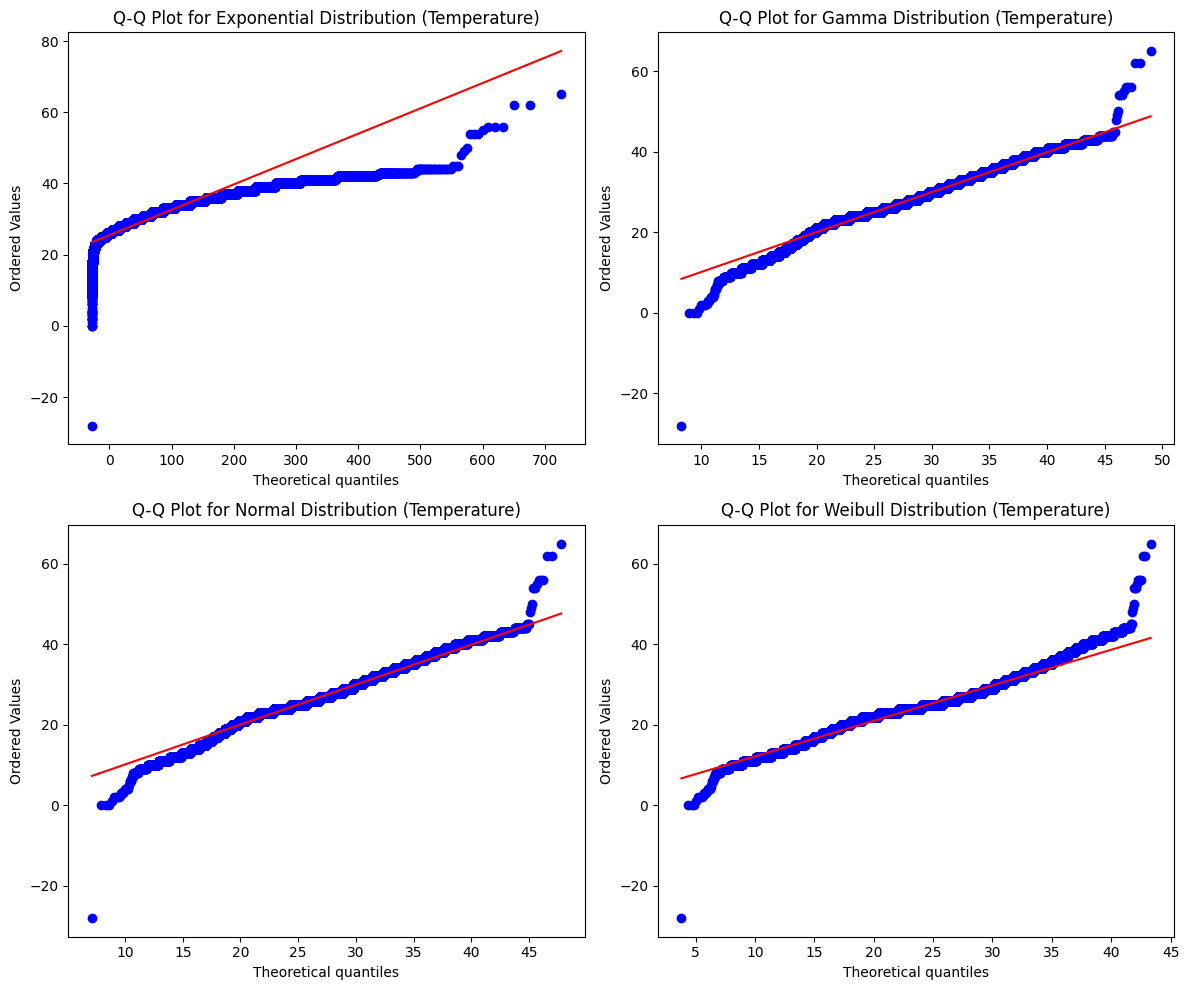

In [40]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Fitted parameters for each distribution
fitted_params_temp = {
    'Exponential': stats.expon.fit(nigeria_temperature_series),
    'Gamma': stats.gamma.fit(nigeria_temperature_series),
    'Normal': stats.norm.fit(nigeria_temperature_series),
    'Weibull': stats.weibull_min.fit(nigeria_temperature_series)
}

# Generate Q-Q plots for temperature
plt.figure(figsize=(12, 10))

# Map names to correct scipy.stats distribution objects
dist_functions = {
    'Exponential': stats.expon,
    'Gamma': stats.gamma,
    'Normal': stats.norm,
    'Weibull': stats.weibull_min
}

for i, (name, params) in enumerate(fitted_params_temp.items(), 1):
    plt.subplot(2, 2, i)
    dist = dist_functions[name]  # Access the correct distribution object
    stats.probplot(nigeria_temperature_series, dist=dist, sparams=params, plot=plt)
    plt.title(f"Q-Q Plot for {name} Distribution (Temperature)")

plt.tight_layout()
plt.show()

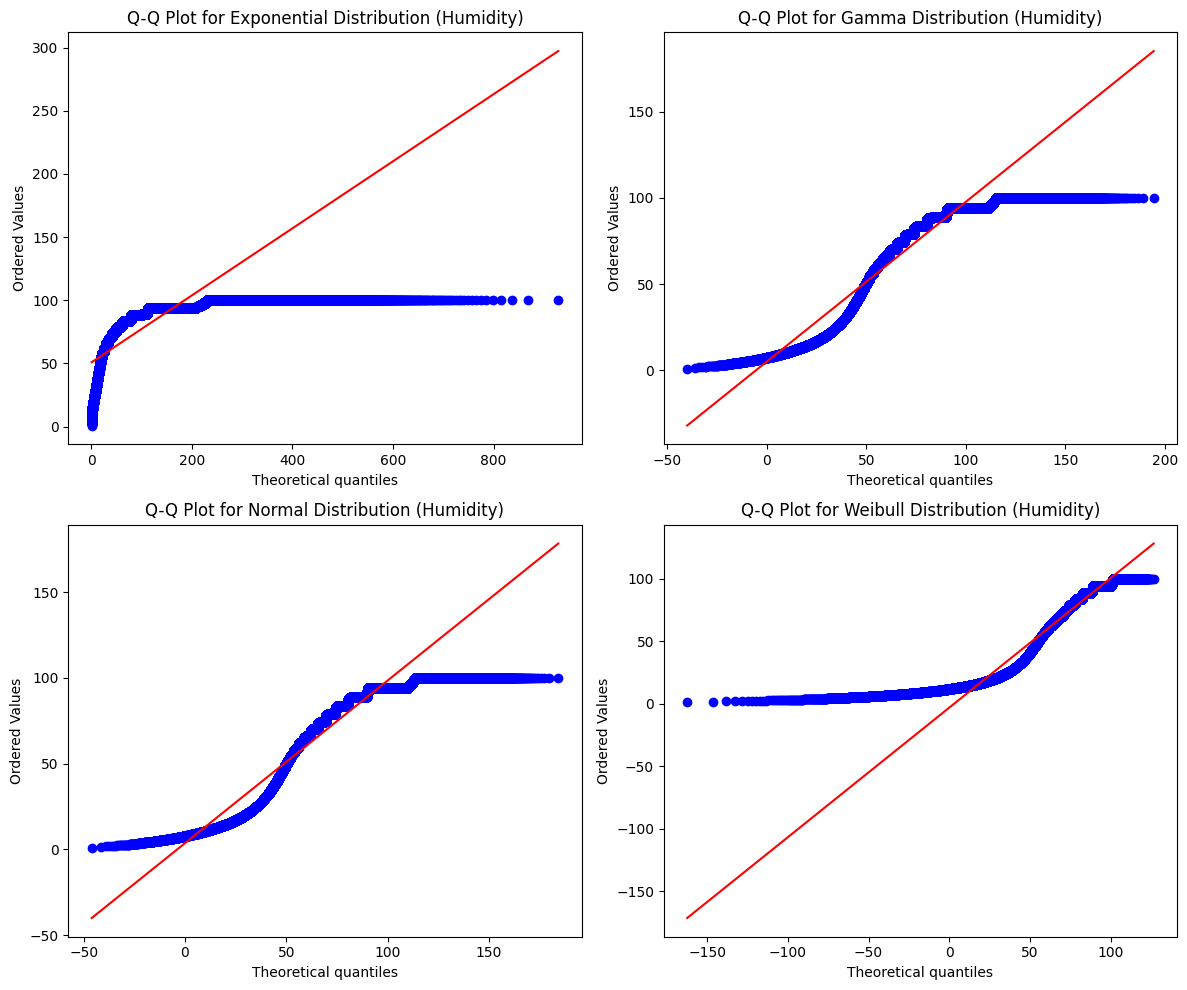

In [44]:
import numpy as np
import scipy.stats as stats
# Fitted parameters for each distribution for humidity
fitted_params_humid = {
    'Exponential': stats.expon.fit(nigeria_humidity_series),
    'Gamma': stats.gamma.fit(nigeria_humidity_series),
    'Normal': stats.norm.fit(nigeria_humidity_series),
    'Weibull': stats.weibull_min.fit(nigeria_humidity_series)
}

# Generate Q-Q plots for humidity
plt.figure(figsize=(12, 10))

for i, (name, params) in enumerate(fitted_params_humid.items(), 1):
    plt.subplot(2, 2, i)

    # Select the appropriate distribution function
    if name == 'Exponential':
        dist = stats.expon
    elif name == 'Gamma':
        dist = stats.gamma
    elif name == 'Normal':
        dist = stats.norm
    elif name == 'Weibull':
        dist = stats.weibull_min

    # Generate Q-Q plot
    stats.probplot(nigeria_humidity_series, dist=dist, sparams=params, plot=plt)
    plt.title(f"Q-Q Plot for {name} Distribution (Humidity)")

plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import weibull_min, norm, gamma, expon

# Load the data
temperature_data = pd.read_csv('C:/Users/Ohellay/Desktop/temperature_file.csv')
humidity_data = pd.read_csv('C:/Users/Ohellay/Desktop/humidity_file.csv')

# Replace station IDs with station names
station_name_map = {
    "DNAA": "Abuja", "DNAK": "Akure", "DNBE": "Benin", "DNCA": "Calabar", "DNEN": "Enugu",
    "DNGO": "Gombe", "DNIB": "Ibadan", "DNIL": "Ilorin", "DNIM": "Imo", "DNJO": "Jos",
    "DNKA": "Kaduna", "DNKN": "Kano", "DNKT": "Katsina", "DNMA": "Maiduguri", "DNMK": "Makurdi",
    "DNMM": "Lagos", "DNMN": "Minna", "DNOS": "Osogbo", "DNPO": "Port Harcourt", "DNSO": "Sokoto",
    "DNYO": "Yola", "DNZA": "Zaria"
}

temperature_data['station'] = temperature_data['station'].map(station_name_map)
humidity_data['station'] = humidity_data['station'].map(station_name_map)

# Ensure numeric values and handle invalid entries
temperature_data['tmpc'] = pd.to_numeric(temperature_data['tmpc'], errors='coerce')
humidity_data['relh'] = pd.to_numeric(humidity_data['relh'], errors='coerce')

# Drop rows with NaN values in the relevant columns
temperature_data_cleaned = temperature_data.dropna(subset=['tmpc'])
humidity_data_cleaned = humidity_data.dropna(subset=['relh'])

# Define a function to calculate AIC and BIC for a dataset
def calculate_aic_bic(data, dist_name):
    n = len(data)
    
    if dist_name == 'weibull':
        params = weibull_min.fit(data)
        fitted_dist = weibull_min(*params)
        k = len(params)
    elif dist_name == 'normal':
        params = norm.fit(data)
        fitted_dist = norm(*params)
        k = len(params)
    elif dist_name == 'gamma':
        params = gamma.fit(data)
        fitted_dist = gamma(*params)
        k = len(params)
    elif dist_name == 'exponential':
        params = expon.fit(data)
        fitted_dist = expon(*params)
        k = len(params)
    else:
        return None, None, None

    # Log-likelihood
    log_likelihood = np.sum(fitted_dist.logpdf(data))
    
    # AIC and BIC calculations
    aic = 2 * k - 2 * log_likelihood
    bic = k * np.log(n) - 2 * log_likelihood
    
    return aic, bic, params

# List of distributions to test
distributions = ['weibull', 'normal', 'gamma', 'exponential']

# Function to fit distributions for each station
def fit_distributions_by_station(data, value_column, station_column):
    results = []
    grouped = data.groupby(station_column)
    
    for station, group in grouped:
        station_results = {'station': station}
        for dist in distributions:
            aic, bic, params = calculate_aic_bic(group[value_column].values, dist)
            station_results[f'{dist}_aic'] = aic
            station_results[f'{dist}_bic'] = bic
            station_results[f'{dist}_params'] = params
        results.append(station_results)
    
    return pd.DataFrame(results)

# Fit distributions for temperature and humidity by station
temperature_results = fit_distributions_by_station(temperature_data_cleaned, 'tmpc', 'station')
humidity_results = fit_distributions_by_station(humidity_data_cleaned, 'relh', 'station')

# Save results to CSV
temperature_results.to_csv('temperature_fits_by_station.csv', index=False)
humidity_results.to_csv('humidity_fits_by_station.csv', index=False)

# Display a snippet of the results
print("Temperature Results by Station:")
print(temperature_results.head())

print("\nHumidity Results by Station:")
print(humidity_results.head())

Temperature Results by Station:
   station   weibull_aic   weibull_bic  \
0    Abuja           inf           inf   
1    Akure           inf           inf   
2    Benin  3.789269e+04  3.791338e+04   
3  Calabar           inf           inf   
4    Enugu           inf           inf   

                                      weibull_params     normal_aic  \
0  (3.801821235503424, 11.992519911644983, 16.919...  401634.399182   
1  (3.6967892054297904, 13.824972055035408, 15.25...   28523.823501   
2  (3.14162510700707, 18.944606298624755, 10.4586...   38055.759185   
3  (2.943441326913331, 19.953199229047357, 8.4491...   43845.954588   
4  (3.486126691557521, 15.935650185831982, 13.446...  109109.192975   

      normal_bic                             normal_params      gamma_aic  \
0  401652.700566    (27.28843690742975, 4.331179675933505)  399157.796069   
1   28536.895139    (27.62675696898312, 3.976555342017599)   28488.635608   
2   38069.555643   (28.291053422598715, 3.256263821534645

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.stats import gamma, weibull_min, expon, norm

# File paths (update with actual paths)
humidity_file_path = "C:/Users/Ohellay/Desktop/humidity_file.csv"
temperature_file_path = "C:/Users/Ohellay/Desktop/temperature_file.csv"

# Load the datasets
humidity_data = pd.read_csv(humidity_file_path)
temperature_data = pd.read_csv(temperature_file_path)

# Map station IDs to names
station_name_map = {
    "DNAA": "Abuja", "DNAK": "Akure", "DNBE": "Benin", "DNCA": "Calabar", "DNEN": "Enugu",
    "DNGO": "Gombe", "DNIB": "Ibadan", "DNIL": "Ilorin", "DNIM": "Imo", "DNJO": "Jos",
    "DNKA": "Kaduna", "DNKN": "Kano", "DNKT": "Katsina", "DNMA": "Maiduguri", "DNMK": "Makurdi",
    "DNMM": "Lagos", "DNMN": "Minna", "DNOS": "Osogbo", "DNPO": "Port Harcourt", "DNSO": "Sokoto",
    "DNYO": "Yola", "DNZA": "Zaria"
}

humidity_data['station'] = humidity_data['station'].map(station_name_map)
temperature_data['station'] = temperature_data['station'].map(station_name_map)

# Convert to numeric, coercing errors to NaN
humidity_data['relh'] = pd.to_numeric(humidity_data['relh'], errors='coerce')
temperature_data['tmpc'] = pd.to_numeric(temperature_data['tmpc'], errors='coerce')

# Drop rows with NaN
humidity_data_cleaned = humidity_data.dropna(subset=['relh'])
temperature_data_cleaned = temperature_data.dropna(subset=['tmpc'])

# Function to calculate descriptive statistics
def descriptive_stats(data, label):
    stats = {
        "Mean": np.mean(data),
        "Median": np.median(data),
        "Standard Deviation": np.std(data),
        "Minimum": np.min(data),
        "Maximum": np.max(data),
        "Skewness": skew(data),
        "Kurtosis": kurtosis(data)
    }
    print(f"\nDescriptive Statistics for {label}:")
    for k, v in stats.items():
        print(f"{k}: {v:.2f}")
    return stats

# Function to fit distributions and calculate AIC/BIC
def fit_distribution(data, dist_name, dist):
    params = dist.fit(data)
    log_likelihood = np.sum(dist.logpdf(data, *params))
    k = len(params)
    aic = 2 * k - 2 * log_likelihood
    bic = k * np.log(len(data)) - 2 * log_likelihood
    return {"name": dist_name, "AIC": aic, "BIC": bic, "params": params}

# Select one state from each geopolitical zone
geo_zone_states = {
    "North Central": "Abuja",
    "North East": "Maiduguri",
    "North West": "Sokoto",
    "South East": "Enugu",
    "South South": "Calabar",
    "South West": "Lagos"
}

results = []

for zone, state in geo_zone_states.items():
    # Filter data for the selected state
    temp_state_data = temperature_data_cleaned[temperature_data_cleaned['station'] == state]['tmpc']
    hum_state_data = humidity_data_cleaned[humidity_data_cleaned['station'] == state]['relh']
    
    if temp_state_data.empty or hum_state_data.empty:
        print(f"Data for {state} in {zone} is missing or insufficient.")
        continue
    
    print(f"\nProcessing data for {state} in {zone}...")
    
    # Descriptive statistics
    temp_stats = descriptive_stats(temp_state_data, f"Temperature in {state}")
    hum_stats = descriptive_stats(hum_state_data, f"Humidity in {state}")
    
    # Fit distributions
    distributions = {"Gamma": gamma, "Weibull": weibull_min, "Exponential": expon, "Normal": norm}
    temp_fits = [fit_distribution(temp_state_data, name, dist) for name, dist in distributions.items()]
    hum_fits = [fit_distribution(hum_state_data, name, dist) for name, dist in distributions.items()]
    
    # Collect results
    results.append({
        "Zone": zone,
        "State": state,
        "Temperature Stats": temp_stats,
        "Humidity Stats": hum_stats,
        "Temperature Fits": sorted(temp_fits, key=lambda x: x['AIC']),
        "Humidity Fits": sorted(hum_fits, key=lambda x: x['AIC'])
    })

# Output summarized results
for result in results:
    print(f"\nZone: {result['Zone']}, State: {result['State']}")
    print(f"Best Temp Fit: {result['Temperature Fits'][0]}")
    print(f"Best Humidity Fit: {result['Humidity Fits'][0]}")


Processing data for Abuja in North Central...

Descriptive Statistics for Temperature in Abuja:
Mean: 27.29
Median: 27.00
Standard Deviation: 4.33
Minimum: 4.00
Maximum: 62.00
Skewness: 0.41
Kurtosis: -0.42

Descriptive Statistics for Humidity in Abuja:
Mean: 63.81
Median: 69.52
Standard Deviation: 23.39
Minimum: 5.09
Maximum: 100.00
Skewness: -0.56
Kurtosis: -0.71

Processing data for Maiduguri in North East...

Descriptive Statistics for Temperature in Maiduguri:
Mean: 30.58
Median: 31.00
Standard Deviation: 5.99
Minimum: 8.00
Maximum: 49.00
Skewness: -0.37
Kurtosis: 0.07

Descriptive Statistics for Humidity in Maiduguri:
Mean: 34.11
Median: 27.45
Standard Deviation: 20.76
Minimum: 3.68
Maximum: 100.00
Skewness: 0.98
Kurtosis: 0.12

Processing data for Sokoto in North West...

Descriptive Statistics for Temperature in Sokoto:
Mean: 30.60
Median: 31.00
Standard Deviation: 5.37
Minimum: 7.90
Maximum: 50.00
Skewness: -0.06
Kurtosis: -0.38

Descriptive Statistics for Humidity in Sokoto:

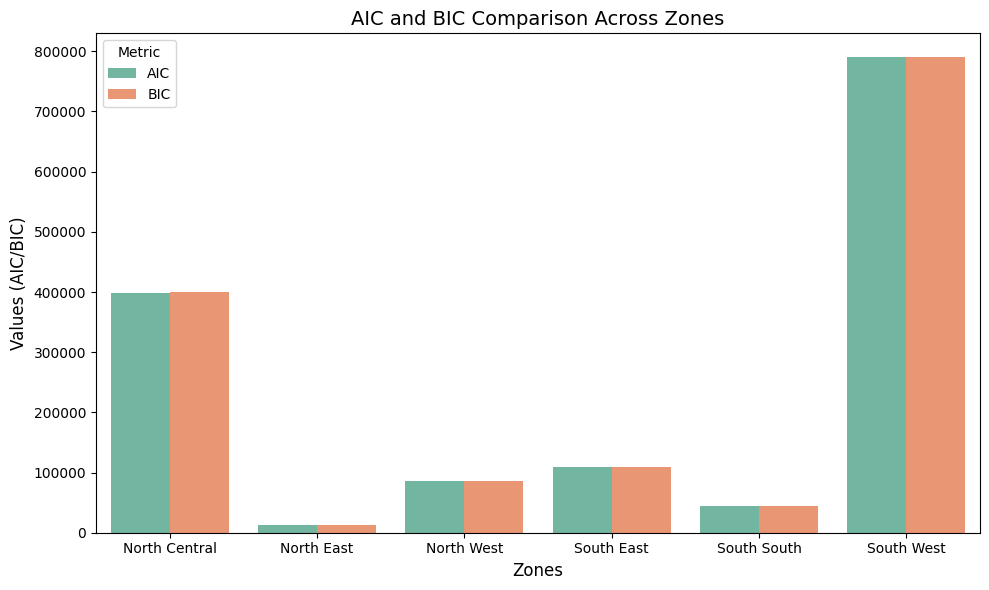

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample Data (Replace with your AIC/BIC data)
data = {
    "Zone": ["North Central", "North Central","North East","North East", "North West","North West", "South East",  "South East","South South","South South", "South West", "South West"],
    "Metric": ["AIC", "BIC", "AIC", "BIC", "AIC", "BIC","AIC", "BIC","AIC", "BIC","AIC", "BIC"],
    "Value": [399157.80,399185.25,12280.82,12297.50,86351.58,86366.66,108966.05,108989.73,43845.95,43860.14,790292.48,790322.45]

}
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="Zone", y="Value", hue="Metric", data=df, palette="Set2")
plt.title("AIC and BIC Comparison Across Zones", fontsize=14)
plt.xlabel("Zones", fontsize=12)
plt.ylabel("Values (AIC/BIC)", fontsize=12)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


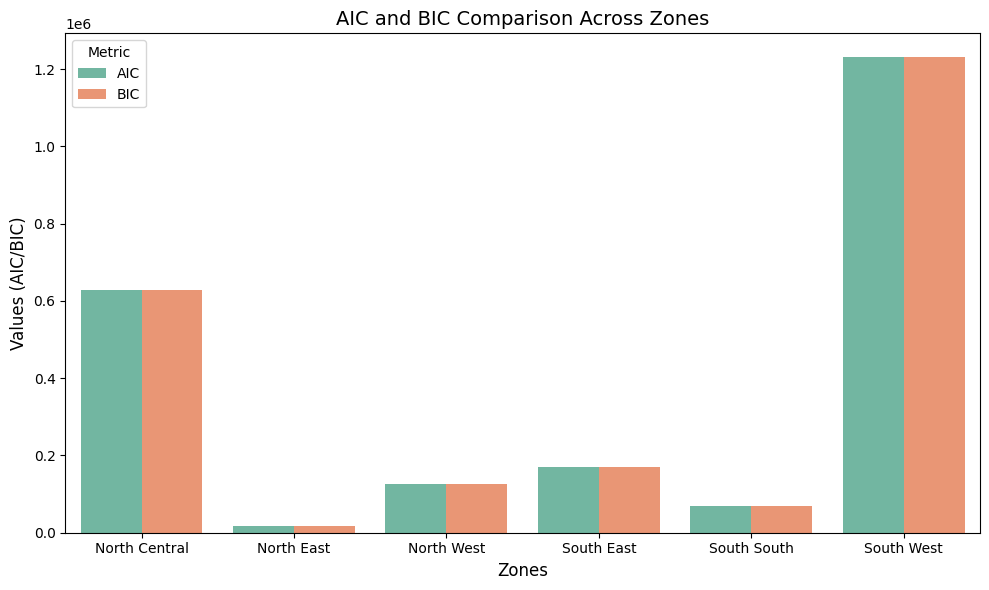

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample Data (Replace with your AIC/BIC data)
data = {
    "Zone": ["North Central", "North Central","North East","North East", "North West","North West", "South East",  "South East","South South","South South", "South West", "South West"],
    "Metric": ["AIC", "BIC", "AIC", "BIC", "AIC", "BIC","AIC", "BIC","AIC", "BIC","AIC", "BIC"],
    "Value": [627977.57,628005.02,16427.48,16444.16,126637.11,126659.72,171305.17,171328.86,69039.15,69060.42,1231402.07,	1231432.04]

}
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="Zone", y="Value", hue="Metric", data=df, palette="Set2")
plt.title("AIC and BIC Comparison Across Zones", fontsize=14)
plt.xlabel("Zones", fontsize=12)
plt.ylabel("Values (AIC/BIC)", fontsize=12)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()